# Housing in Mexico

In this project we will create a Machine Learning model that will predict the appartments price. We will use Linear Regression model for this project.

In [126]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

 Automating the data importing and cleaning process through the use of functions can provide a standardized approach for data analysis, ensuring consistency and reproducibility. This approach saves time and identifies inconsistencies or errors in the data in a systematic manner. Functions are also easily modifiable and can be adapted to different datasets or changing data requirements, making data analysis more efficient and accurate. So we will create a function name "Wrangle" that will take the filepath and will return the clean Dataframe.
 

In [102]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    # Subset data: Apartments in "Capital Federal", less than 4000
    mask_apt=df["property_type"]=="apartment"
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price=df["price_aprox_usd"]<4000
    
   # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high =df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area=df["surface_covered_in_m2"].between(low, high)
    mask_area1=df["surface_covered_in_m2"]>20
    
    df=df[mask_apt & mask_ba & mask_price & mask_area & mask_area1]
    
    #dropping lat & lon column
    df.drop(columns=["lat-lon"], inplace=True)
    
    #dropping place_with_parent_names column because we have the column with place name
    df.drop(columns=["place_with_parent_names", "place_name"], inplace=True)
    
    #dropping columns with high null count
    df.drop(columns=["geonames_id", "surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", "rooms" , "expenses"], inplace=True)
    
    #dropping columns which have high cardinality and low cardinality
    df.drop(columns=["created_on", "operation", "property_type", "currency", "properati_url","description", "title", "image_thumbnail"], inplace=True)
    
    #dropping leaky features 
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2"], inplace=True)
    
    #dropping  na rows
    df.dropna(inplace=True)
    
    return df

In [103]:
df=wrangle("properati-MX-2016-11-01-properties-rent.csv")
df.head()

,lat,lon,price_aprox_usd,surface_covered_in_m2
40,19.455980,-99.195425,411.39,64.0
42,19.388898,-99.265262,1190.88,215.0
43,19.375577,-99.249248,1245.01,147.0
45,19.465074,-99.153608,460.11,65.0
49,19.463983,-99.156004,541.31,76.0


In [7]:
df["property_type"].unique()

array(['house', 'apartment', 'store'], dtype=object)

By viewing the Property type columns we have seen that there are 4 different types of properties in data set but we will work with the apartment. later on we will build model to predict the apartment prices

In [47]:
mask_a=df["place_with_parent_names"].str.contains("Tamaulipas")
len(df[mask_a])

425

After Analyzing States in Data set came to the conclusion that most apartments are from "Distrito Federal". so to make a mask to trim the data to only the apartments that are in "Distrito Federal".

In [4]:
df["mexican_states"]=df["place_with_parent_names"].str.split("|", expand=True)[2]
df["mexican_states"].value_counts()


Distrito Federal                   2949
Quintana Roo                        986
Estado de México                    979
Veracruz de Ignacio de la Llave     926
Puebla                              837
Nuevo León                          829
Yucatán                             750
Querétaro                           725
Guerrero                            592
São Paulo                           447
Tamaulipas                          425
San Luis Potosí                     399
Morelos                             366
Jalisco                             312
Tabasco                             295
Chihuahua                           125
Baja California                     104
Sinaloa                             101
Guanajuato                           98
Campeche                             88
Chiapas                              87
Nayarit                              63
Oaxaca                               33
Aguascalientes                       31
Sonora                               31


In [100]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 40 to 37595
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lat                    1972 non-null   float64
 1   lon                    1972 non-null   float64
 2   price_aprox_usd        1972 non-null   float64
 3   surface_covered_in_m2  1972 non-null   float64
dtypes: float64(4)
memory usage: 77.0 KB


we see that there are alot of outliers in our data 75% apartments in our dataset price less than 3000 so we have to remove the outliers to improve the result of our model. so we decided to just keep the apartments price less than 4000

In [67]:
df.describe()["surface_covered_in_m2"]


count    2306.000000
mean      136.951865
std        76.599762
min        25.000000
25%        80.000000
50%       112.500000
75%       180.000000
max       400.000000
Name: surface_covered_in_m2, dtype: float64

we see that most of the apartments covers the area less than 180 meter square. our data is skewed so we have to remove the outliers from the data

scatter plot to see the relationship between surface area covered and price

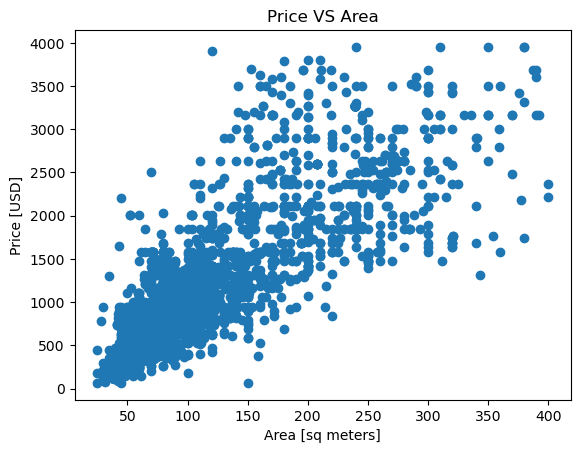

In [151]:
plt.scatter(x=df["surface_covered_in_m2"], y= df["price_aprox_usd"])

plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Price VS Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

In [81]:
df.isnull().sum()/len(df)

created_on                    0.000000
operation                     0.000000
property_type                 0.000000
place_name                    0.000000
lat                           0.144840
lon                           0.144840
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_covered_in_m2         0.000000
price_per_m2                  0.000000
properati_url                 0.000000
description                   0.000000
title                         0.000000
image_thumbnail               0.076756
dtype: float64

The next thing we need to look out for are categorical columns with low or high cardinality. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Here we can see that operation and property type have only 1 value and other columns have too many unique values. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

# Split Data

In [131]:
target = "price_aprox_usd"
features=["surface_covered_in_m2","lat","lon"]
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.2, random_state =42)

# Baseline

In [132]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)

print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", round(mean_absolute_error(y_train,y_pred_baseline),2))

Mean apt price: 1387.25
Baseline MAE: 685.58


Mean apartment price is about 1383.48 and if we always guess by average we will be off by around 678.17 .

# Model Building

In [133]:
model= LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [146]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 389.72


In [152]:
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", round(mae_test, 2))

Test MAE: 380.75


so we can see that our model is performing good beating the Baseline MAE.